<a href="https://colab.research.google.com/github/Fabiorsi1979/DS-Comunidade/blob/main/SQL_intermediario_cuidados_uniao_tabelas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Quais cuidados devemos ter na montagem de um tabelão

#### - Entender do negócio
#### - Analisar cada tabela isoladamente, para entender cada coluna
#### - Entender a relação entre elas pensando no modelo de negócio da empresa
#### - Assim que fizer a junção, verificar se existe duplicidade, em qual colunas e se isso faz sentido ou não.

In [143]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [144]:
path = '/content/drive/MyDrive/db_olist.sqlite'

In [145]:
import sqlite3
import pandas as pd

In [146]:
def investigando_sql (*args):
  conexao = sqlite3.connect(path)
  cursor = conexao.cursor()

  cursor.execute(consulta)
  dados = cursor.fetchall()

  cursor.close()
  conexao.close()

  invest = pd.DataFrame(data=dados)

  return invest

### Quantas e quais tabelas tem esse banco de dados?

In [149]:
consulta = "SELECT name FROM sqlite_master WHERE type='table'"
tabelas = investigando_sql(consulta)
tabelas

,0
0,customer
1,geolocation
2,order_items
3,order_payments
4,order_reviews
5,orders
6,products
7,sellers
8,product_category_name
9,order_review_shorts


#### Quais as colunas de cada tabela?

In [150]:
analise = []
for i in range (0, len(tabelas)):
  consulta = f"PRAGMA TABLE_INFO('{tabelas[0][i]}');"
  colunas = investigando_sql(consulta)
  for n in range(0,len(colunas)):
      analise.append((tabelas[0][i],colunas[1][n],colunas[2][n]))

colunas = pd.DataFrame (data = analise, columns=['Tabela','Coluna','Tipo'])
colunas

,Tabela,Coluna,Tipo
0,customer,customer_id,TEXT
1,customer,customer_unique_id,TEXT
2,customer,customer_zip_code_prefix,INTEGER
3,customer,customer_city,TEXT
4,customer,customer_state,TEXT
...,...,...,...
61,order_review_backup,review_score,INTEGER
62,order_review_backup,review_comment_title,TEXT
63,order_review_backup,review_comment_message,TEXT
64,order_review_backup,review_creation_date,TIMESTAMP


### Analisando tabelas e colunas separadamente

In [151]:
Escolha_Tabela = 1 # @param {type:"slider", min:0, max:10, step:1}
coluna = colunas.loc[colunas["Tabela"]==tabelas[0][Escolha_Tabela]]
coluna

,Tabela,Coluna,Tipo
5,geolocation,geolocation_zip_code_prefix,INTEGER
6,geolocation,geolocation_lat,REAL
7,geolocation,geolocation_lng,REAL
8,geolocation,geolocation_city,TEXT
9,geolocation,geolocation_state,TEXT


#### Identifique quais os tipos de dados que cada registro guarda, tente identificar quais as 'primary keys' e 'forest keys'.

In [152]:
# Aqui é possivel detalhar o que foi analisado n atabela acima, ou seja,
# na consulta anterior você identificou os campos e aqui você analisa o conteúdo dos campos
# para encontrar as primary e forest keys
consulta = f"SELECT * FROM {tabelas[0][Escolha_Tabela]}"
resposta = investigando_sql(consulta)
col = coluna.iloc[:,1].tolist()
resposta.columns = [col]
print (f"A tabela que está sendo analisada é: {tabelas[0][Escolha_Tabela]}")
print ("____________________________________________________________________")
resposta.head(10)

A tabela que está sendo analisada é: geolocation
____________________________________________________________________


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
5,1012,-23.547762,-46.635361,são paulo,SP
6,1047,-23.546273,-46.641225,sao paulo,SP
7,1013,-23.546923,-46.634264,sao paulo,SP
8,1029,-23.543769,-46.634278,sao paulo,SP
9,1011,-23.547640,-46.636032,sao paulo,SP


#### Construção do "TABELÃO"

In [159]:
# três tabelas não irão fazer parte deste tabelão, pois não agregram valor ao resultado
# sendo: Order_review_backup, Order_review_shorts e Product_category_name
consulta = """
SELECT
  o.order_id,
  o.order_status,
  o.order_approved_at,
  o.order_estimated_delivery_date,
  oi.product_id,
  p.product_category_name,
  c.customer_id,
  c.customer_city,
  c.customer_state,
  s.seller_id,
  s.seller_city,
  s.seller_state,
  op.payment_type,
  op.payment_installments,
  op.payment_value,
  orr.review_score,
  orr.review_comment_title,
  orr.review_comment_message
FROM orders o LEFT JOIN customer c         ON ( c.customer_id = o.customer_id )
             LEFT JOIN order_items oi     ON ( oi.order_id = o.order_id )
             LEFT JOIN products p         ON ( p.product_id = oi.product_id )
             LEFT JOIN sellers s          ON ( s.seller_id = oi.seller_id )
             LEFT JOIN geolocation g      ON ( g.geolocation_zip_code_prefix = c.customer_zip_code_prefix )
             LEFT JOIN order_payments op  ON ( op.order_id = o.order_id )
             LEFT JOIN order_reviews orr  ON ( orr.order_id = o.order_id )
LIMIT 5;
"""
resultado = investigando_sql(consulta)
resultado.columns =["Pedido","Status","Data aprovação","Data estimada entrega","Produtos","Categoria produto","Cliente","Cidade cli","UF cli",
                    "Vendedor","Cidade vend","UF vend","Tipo pagamento","Parcelas","Valor pago","Pontuação","Titulo Comenstários","Mensagem"]
resultado

,Pedido,Status,Data aprovação,Data estimada entrega,Produtos,Categoria produto,Cliente,Cidade cli,UF cli,Vendedor,Cidade vend,UF vend,Tipo pagamento,Parcelas,Valor pago,Pontuação,Titulo Comenstários,Mensagem
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 11:07:15,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,utilidades_domesticas,9ef432eb6251297304e76186b10a928d,sao paulo,SP,3504c0cb71d7fa48d967e0e4c94d59d9,maua,SP,credit_card,1,18.12,4,None,"Não testei o produto ainda, mas ele veio corre..."
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 11:07:15,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,utilidades_domesticas,9ef432eb6251297304e76186b10a928d,sao paulo,SP,3504c0cb71d7fa48d967e0e4c94d59d9,maua,SP,voucher,1,2.00,4,None,"Não testei o produto ainda, mas ele veio corre..."
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 11:07:15,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,utilidades_domesticas,9ef432eb6251297304e76186b10a928d,sao paulo,SP,3504c0cb71d7fa48d967e0e4c94d59d9,maua,SP,voucher,1,18.59,4,None,"Não testei o produto ainda, mas ele veio corre..."
3,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 11:07:15,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,utilidades_domesticas,9ef432eb6251297304e76186b10a928d,sao paulo,SP,3504c0cb71d7fa48d967e0e4c94d59d9,maua,SP,credit_card,1,18.12,4,None,"Não testei o produto ainda, mas ele veio corre..."
4,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 11:07:15,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,utilidades_domesticas,9ef432eb6251297304e76186b10a928d,sao paulo,SP,3504c0cb71d7fa48d967e0e4c94d59d9,maua,SP,voucher,1,2.00,4,None,"Não testei o produto ainda, mas ele veio corre..."


#### Relacionamento entre as colunas, observando os dados e as junções:
~~~ Python
FROM orders o LEFT JOIN customer c         ON ( c.customer_id = o.customer_id )
             LEFT JOIN order_items oi     ON ( oi.order_id = o.order_id )
             LEFT JOIN products p         ON ( p.product_id = oi.product_id )
             LEFT JOIN sellers s          ON ( s.seller_id = oi.seller_id )
             LEFT JOIN geolocation g      ON ( g.geolocation_zip_code_prefix = c.customer_zip_code_prefix )
             LEFT JOIN order_payments op  ON ( op.order_id = o.order_id )
             LEFT JOIN order_reviews orr  ON ( orr.order_id = o.order_id )
~~~

image = /content/drive/MyDrive/CARDINALIDADE.jpg

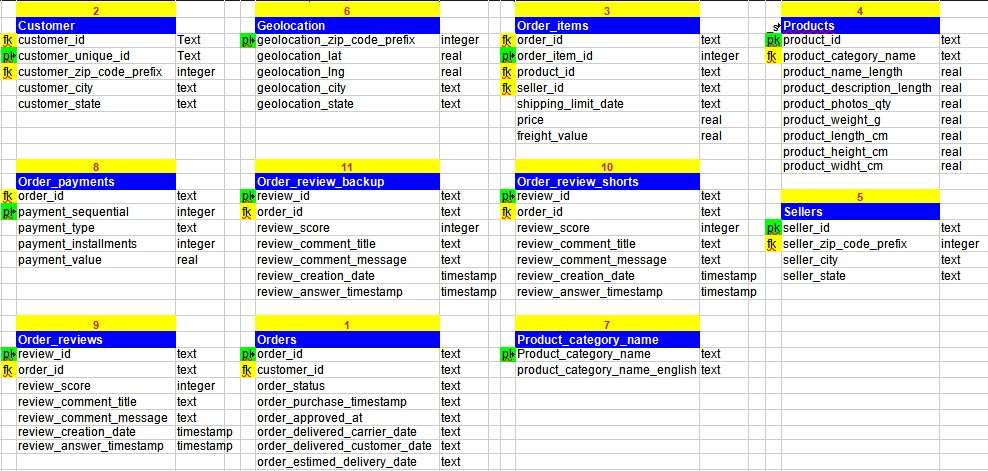